Since we decided to work with frequencies from 0 to 100 Hz, and the goal is to suppress noise to better isolate the signal on the spectrogram, the best option is to apply filters that remove both low-frequency and high-frequency noise that does not belong to the desired range.

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
import scipy.signal as signal
import pywt

In [4]:
# Mars sample

# Get catalog
cat_directory = './data/mars/training/catalogs/'
cat_file = cat_directory + 'Mars_InSight_training_catalog_final.csv'
cat = pd.read_csv(cat_file)

# Get all useful data from a catalog file
row = cat.iloc[1]

arrival_time_rel = row['time_rel(sec)']

data_directory = './data/mars/training/data/'
data_file = f'{data_directory}{row.filename[:-4]}.mseed'
data_cat = read(data_file)

# Read in time steps and velocities
times = data_cat.traces[0].times()
data = data_cat.traces[0].data

sample_rate = times[1] - times[0]
samples = data

In [5]:
# Functions and additional data

scales = np.arange(1, 64, 0.5)

def cwt_wavelet_transform(signal, sample_rate, wavelet='morl'):
    coef, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/sample_rate)
    return coef, freqs

def scale_to_frequency(scales, wavelet, sample_rate):
    frequencies = pywt.scale2frequency(wavelet, scales) * sample_rate
    return frequencies

In [43]:
# Filter
    
# Sample rate and desired cutoff frequency (in Hz)
fs = 1000.0  # Sample rate
cutoff = 100  # Desired cutoff frequency of the filter

# Normalize the frequency
nyquist = 0.5 * fs
normal_cutoff = cutoff / nyquist
# Get the filter coefficients
b, a = signal.butter(4, normal_cutoff, btype='low', analog=False)

# Apply the low-pass filter
samples = signal.filtfilt(b, a, samples)

In [44]:
coef, new_scales = cwt_wavelet_transform(samples, sample_rate)
frequencies = scale_to_frequency(new_scales, 'morl', sample_rate)

coef = coef / np.mean(np.abs(coef))

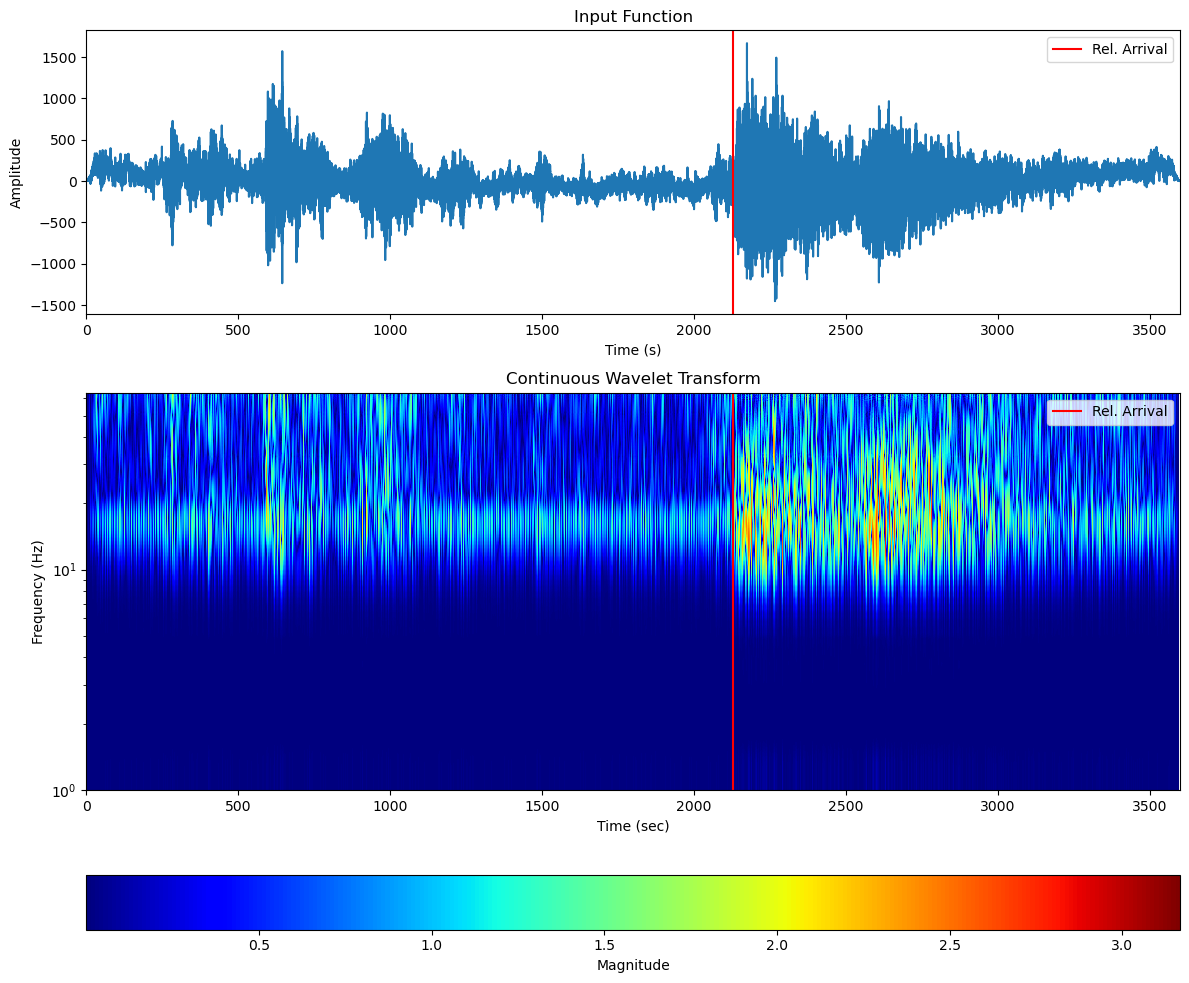

In [45]:
# Plotting the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 2]})

# Plot the input function
ax1.set_xlim(0, times.max())  # Set the x-axis limits
ax1.plot(times, data)
ax1.set_title('Input Function')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot where the arrival time is
arrival_line = ax1.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax1.legend(handles=[arrival_line])

im = ax2.imshow(np.log1p(np.abs(coef)), extent=[times.min(), times.max(), frequencies.min(), frequencies.max()],
            cmap='jet', aspect='auto', origin='lower')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_xlabel('Time (sec)')
ax2.set_title('Continuous Wavelet Transform')
ax2.set_yscale('log')

# Plot where the arrival time is
arrival_line = ax2.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax2.legend(handles=[arrival_line])

# Add colorbar
cbar = fig.colorbar(im, ax=ax2, orientation='horizontal')
cbar.set_label('Magnitude')

# Adjust layout
plt.tight_layout()

plt.show()